<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 2: deep learning для обработки звука</center></h2>

# Введение

В этом задании Вы поработаете и разберетесь в деталях с форматами представления аудиоданных в задачах глубинного обучения, а так же напишете несколько моделей для классификации аудиозаписей.

В процессе выполнения Вы познакомитесь:
* С алгоритмом построения Мел-спектрограммы
* Рекуррентными и сверточными классификаторами аудиоданных
* Алгоритмом аугментации аудиоданных SpecAugment

In [ ]:
#!pip install torch==2.6.0 torchaudio==0.8.0 numpy==1.20.0 NO!

In [ ]:
import torch

torch.manual_seed(42)  # For CPU
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import torch
import torchaudio
from IPython import display
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset

%matplotlib inline

#assert torch.__version__.startswith("1.8.0")
#assert torchaudio.__version__ == "0.8.0"

device = "cuda:0"

# Классификация аудиозаписей.

В этом домашнем задании Вам предстоит классифицировать аудиозаписи из датасета [UrbanSound8K](https://urbansounddataset.weebly.com/urbansound8k.html).

Данный датасет состоит из 8732 записей, разбитых на train/val/test датасеты.

![image](https://paperswithcode.com/media/datasets/UrbanSound8K-0000003722-02faef06.jpg)

Каждая аудиозапись содержит запись шума города и принадлежит одному из 10 классов:

`[air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, street_music]`


## Задание 1 (1 балл). Знакомство с данными.

- Скачайте датасет с [диска](https://disk.yandex.ru/d/LXmjlqdXsgseoQ) c и распакуйте в папку `./data`.
- Положите разархивированные данные рядом с юпитерской тетрадкой.

In [ ]:
link = 'https://disk.yandex.ru/d/LXmjlqdXsgseoQ' # Можно перейти по ссылке и скачать вручную

import requests
url = f"https://cloud-api.yandex.net/v1/disk/public/resources/download?public_key={link}"
response = requests.get(url)
download_url = response.json()["href"]

with open("data.zip", "wb") as file:
    download_response = requests.get(download_url, stream=True)
    for chunk in download_response.iter_content(chunk_size=1024):
        if chunk:
            file.write(chunk)
            file.flush()

! unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/data/1677.wav      
  inflating: data/data/1678.wav      
  inflating: data/data/1679.wav      
  inflating: data/data/168.wav       
  inflating: data/data/1680.wav      
  inflating: data/data/1681.wav      
  inflating: data/data/1686.wav      
  inflating: data/data/1687.wav      
  inflating: data/data/1688.wav      
  inflating: data/data/1689.wav      
  inflating: data/data/1690.wav      
  inflating: data/data/1695.wav      
  inflating: data/data/1697.wav      
  inflating: data/data/1699.wav      
  inflating: data/data/17.wav        
  inflating: data/data/170.wav       
  inflating: data/data/1701.wav      
  inflating: data/data/1702.wav      
  inflating: data/data/1703.wav      
  inflating: data/data/1704.wav      
  inflating: data/data/1705.wav      
  inflating: data/data/1706.wav      
  inflating: data/data/1708.wav      
  inflating: data/data/1709.wav      
  inflating: data/data/171.wav       

- Напишите `AudioDataset` класс, который будет принимать путь к файлам `train_part.csv` и `val_part.csv` и возращать тройки объектов `(x, y, len)`, где `x` - аудиозапись, `y` - класс аудиозаписи, `len` - длина аудиозаписи. Аудиозаписи **не должны постоянно храниться в RAM**, подгрузку _wav_ файлов надо сделать при запросе через `__getitem__` метод. Кроме того, надо сделать паддинг аудиозаписи - если она короче чем `pad_size` параметр, надо дополнять ее нулями.

- С помощью функции `display.Audio` проиграйте в ноутбуке пару аудиозаписей.

In [ ]:
# классы данных
classes = [
    "air_conditioner",
    "car_horn",
    "children_playing",
    "dog_bark",
    "drilling",
    "engine_idling",
    "gun_shot",
    "jackhammer",
    "siren",
    "street_music",
]

In [ ]:
df = pd.read_csv("data/train_part.csv")
df.head()

,ID,Class
0,7131,air_conditioner
1,5658,siren
2,570,drilling
3,57,drilling
4,5253,drilling


In [ ]:
df.iloc[0,1]

'air_conditioner'

In [ ]:
path = os.path.join("./data/data","7131.wav")
x, sample_rate = torchaudio.load(path)
x.shape

torch.Size([1, 176400])

In [ ]:
class AudioDataset(Dataset):
    def __init__(
        self,
        path_to_csv: str,
        path_to_folder: str,
        pad_size: int = 384000,
        sr: int = 44100,
    ):
        self.csv: pd.DataFrame = pd.read_csv(path_to_csv)[["ID", "Class"]]
        self.path_to_folder = path_to_folder
        self.pad_size = pad_size

        self.sr = sr

        self.class_to_idx = {classes[i]: i for i in range(10)}

    def __getitem__(self, index: int):
        ### YOUR CODE IS HERE ######

        file_name = str(self.csv.iloc[index,0]) + ".wav"
        x_path = os.path.join(self.path_to_folder,file_name)
        x_value, sample_rate = torchaudio.load(x_path)
        len_value = x_value.shape[1]

        if x_value.shape[1] < self.pad_size:
          x_value = torch.cat((x_value,torch.zeros((1,self.pad_size - x_value.shape[1]))), dim = 1)
        elif(x_value.shape[1] < self.pad_size):
          print("FUCK")



        y_value = self.class_to_idx[self.csv.iloc[index,1]]



        return{"x" : torch.squeeze(x_value), "y" : y_value, "len" : len_value}

        ### THE END OF YOUR CODE ###

    def __len__(self):
        return self.csv.shape[0]

In [ ]:
# создадим датасеты
train_dataset = AudioDataset("./data/train_part.csv", "./data/data")
val_dataset = AudioDataset("./data/val_part.csv", "./data/data")

In [ ]:
# проверим размеры датасетов
assert len(train_dataset) == 4500
assert len(val_dataset) == 935

In [ ]:
# проверим возращаемые значения __getitem__
item = train_dataset.__getitem__(0)

assert item["x"].shape == (384000,)
assert item["y"] == 0
assert item["len"] == 176400

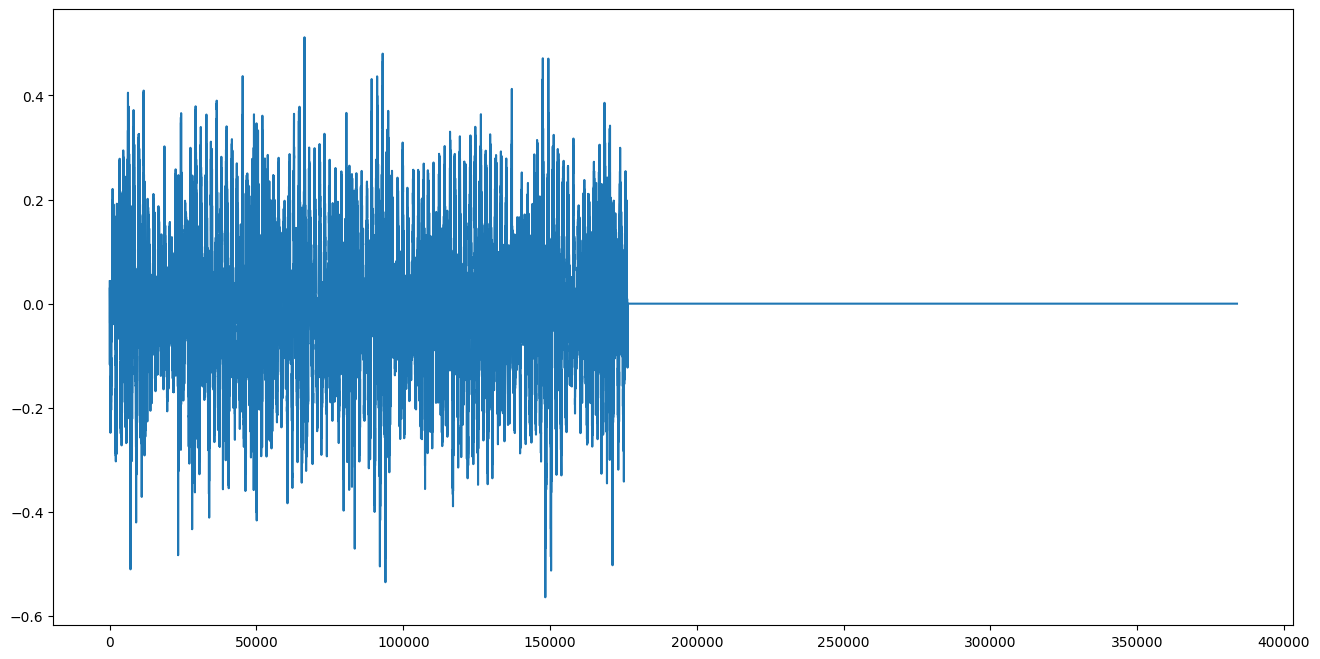

In [ ]:
# нарисуем и проиграем аудиозаписить
item = train_dataset.__getitem__(0)
plt.figure(figsize=(16, 8))
plt.plot(item["x"])

display.Audio(item["x"], rate=train_dataset.sr)

In [ ]:
# создадим даталоадеры
train_dataloader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, pin_memory=True, drop_last=True
)
val_dataloader = DataLoader(val_dataset, batch_size=32, pin_memory=True)

## Задание 2. Рекуррентная сеть для классификации аудиозаписей по сырому сигналу (2 балла)

По своей сути аудиозапись является ни чем иным, как временным рядом - замеры микрофона делаются через равные промежутки времени и хранятся в виде последовательности.

Как известно, рекуррентные сети отлично подходят для работы с различными последовательностями, в том числе и с временными рядами.

Обучим простую реккурентную сеть для классификации аудиозаписей.

1. Разбейте аудизаписить на окошки размером `1024` с шагом `256`. Для этих целей отлично подойдет метод `torch.Tensor.unfold`.
1. Применим к каждому получившемуся окну аудиосигнала полносвязную сеть с активациями `ReLU` и  внутренними размерностям `(1024 -> 256 -> 64 -> 16)`.
2. По получившимся последовательностям пройдемся двунаправленой (`bidirectional=True`) LSTM с двумя слоями (`layers=2`).
3. Склеим c помощью `torch.cat` последние `hidden_state` для каждого слоя и применим к ним полносвязную сеть `(2 * hidden_size * num_layers -> 256 -> 10)` с активацией `ReLU`.

<center>
<img src="https://raw.githubusercontent.com/hse-ds/iad-applied-ds/2020-2023/2022/hw/hw2/imgs/rnn_raw.png" height="500">
</center>

*Совет*: для убыстрения обучения имеет смысл в полносвязные сети добавить `BatchNorm`.

In [ ]:

class RecurrentRawAudioClassifier(nn.Module):
    def __init__(
        self,
        num_classes=10,
        window_length=1024,
        hop_length=256,
        hidden=256,
        num_layers=2,
    ) -> None:
        super().__init__()

        self.window_length = window_length
        self.hop_length = hop_length

        ### YOUR CODE IS HERE ######
        self.first_mlp = nn.Sequential(
            nn.Linear(1024,256),
            nn.ReLU(),

            nn.Linear(256,64),
            nn.ReLU(),

            nn.Linear(64,16),
            nn.ReLU(),

        )

        self.rnn = nn.LSTM(bidirectional = True, num_layers = 2, input_size = 16, hidden_size = 20, batch_first = True)

        self.final_mlp = nn.Sequential(
            nn.BatchNorm1d(80),
            nn.Linear(80,256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256,10),
            nn.Sigmoid()
        )
        ### THE END OF YOUR CODE ###

    def forward(self, x, lens) -> torch.Tensor:
        # разбейте сигнал на окна
        # batch_windows.shape == (B, NUM WINDOWS, 1024)
        batch_windows = x.unfold(1,1024,256)
        X,Y,Z = batch_windows.shape
        # примените к каждому окну полносвязную сеть
        # batch_windows_feautures.shape == (B, NUM WINDOWS, 16)
        batch_windows_feautures = self.first_mlp(batch_windows)

          # your code here

        # примените к получившемся последовательностям LSTM и возьмите hidden state
        current_hidden_state = self.rnn(batch_windows_feautures)[1][0]
        hidden_state_cat = torch.cat((current_hidden_state[0],current_hidden_state[1],current_hidden_state[2],current_hidden_state[3]), dim = 1)

        # склейте hidden_state по слоям
        # hidden_flattened.shape = (B, 2 * hidden_size * num_layers)
        hidden_flattened = self.final_mlp(hidden_state_cat)

        # примените полносвязную сеть и получим логиты классов
        return hidden_flattened  # your code here

In [ ]:
# Создаем 3D тензор (например, размером (3, 3, 3))
tensor = torch.randn(1, 3, 3)
fc = nn.LSTM(bidirectional = True, num_layers = 2, input_size = 3, hidden_size = 10, batch_first = True)
print(len(fc(tensor)))
fc(tensor)[1][0].shape

2


torch.Size([4, 1, 10])

In [ ]:
torch.cat((torch.randn(0),torch.randn(1)), dim = 0)

tensor([-1.0309])

Обучим получившуюся модель.

In [ ]:
def train_audio_clfr(
    model,
    optimizer,
    train_dataloader,
    sr,
    criterion=torch.nn.CrossEntropyLoss(),
    data_transform=None,
    augmentation=None,
    num_epochs=10,
    device="cuda:0",
    verbose_num_iters=10,
):
    model.train()
    iter_i = 0

    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        for batch in train_dataloader:
            x = batch["x"].to(device)
            y = batch["y"].to(device)
            lens = batch["len"].to(device)

            # применяем преобразование входных данных
            if data_transform:
                x, lens = data_transform(x, lens, device=device, sr=sr)

            # примеменяем к логмелспектрограмме аугментацию
            if augmentation:
                x, lens = augmentation(x, lens)

            probs = model(x, lens)
            optimizer.zero_grad()
            loss = criterion(probs, y)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

            # считаем точность предсказания
            pred_cls = probs.argmax(dim=-1)
            train_accuracies.append((pred_cls == y).float().mean().item())

            iter_i += 1

            # раз в verbose_num_iters визуализируем наши лоссы и семплы
            if iter_i % verbose_num_iters == 0:
                clear_output(wait=True)

                print(f"Epoch {epoch}")

                plt.figure(figsize=(10, 5))

                plt.subplot(1, 2, 1)
                plt.xlabel("Iteration")
                plt.ylabel("Train loss")
                plt.plot(np.arange(iter_i), train_losses)

                plt.subplot(1, 2, 2)
                plt.xlabel("Iteration")
                plt.ylabel("Train acc")
                plt.plot(np.arange(iter_i), train_accuracies)

                plt.show()

    model.eval()

In [ ]:
# создадим объекты модели и оптимизатор
rnn_raw = RecurrentRawAudioClassifier()
rnn_raw.to(device)
optim = torch.optim.Adam(rnn_raw.parameters(), lr=3e-4)

Epoch 9


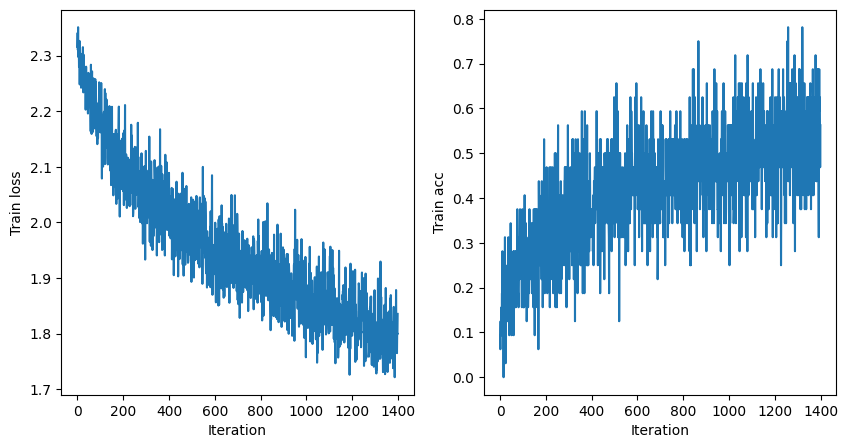

In [ ]:
# обучим модель
train_audio_clfr(rnn_raw, optim, train_dataloader, train_dataset.sr)

Посчитаем метрики на валидационном датасете.

In [ ]:
def plot_confusion_matrix(model, val_dataloader, sr, device, data_transform=None):
    pred_true_pairs = []
    for batch in val_dataloader:
        x = batch["x"].to(device)
        y = batch["y"].to(device)
        lens = batch["len"].to(device)

        with torch.no_grad():
            if data_transform:
                x, lens = data_transform(x, lens, sr=sr, device=device)

            probs = model(x, lens)

            pred_cls = probs.argmax(dim=-1)

        for pred, true in zip(pred_cls.cpu().detach().numpy(), y.cpu().numpy()):
            pred_true_pairs.append((pred, true))

    print(f"Val accuracy: {np.mean([p[0] == p[1] for p in pred_true_pairs])}")

    cm_df = pd.DataFrame(
        confusion_matrix(
            [p[1] for p in pred_true_pairs],
            [p[0] for p in pred_true_pairs],
            normalize="true",
        ),
        columns=classes,
        index=classes,
    )
    sn.heatmap(cm_df, annot=True)

torch.Size([32, 1497, 16])
torch.Size([32, 1497, 16])
torch.Size([32, 1497, 16])
torch.Size([32, 1497, 16])
torch.Size([32, 1497, 16])
torch.Size([32, 1497, 16])
torch.Size([32, 1497, 16])
torch.Size([32, 1497, 16])
torch.Size([32, 1497, 16])
torch.Size([32, 1497, 16])
torch.Size([32, 1497, 16])
torch.Size([32, 1497, 16])
torch.Size([32, 1497, 16])
torch.Size([32, 1497, 16])
torch.Size([32, 1497, 16])
torch.Size([32, 1497, 16])
torch.Size([32, 1497, 16])
torch.Size([32, 1497, 16])
torch.Size([32, 1497, 16])
torch.Size([32, 1497, 16])
torch.Size([32, 1497, 16])
torch.Size([32, 1497, 16])
torch.Size([32, 1497, 16])
torch.Size([32, 1497, 16])
torch.Size([32, 1497, 16])
torch.Size([32, 1497, 16])
torch.Size([32, 1497, 16])
torch.Size([32, 1497, 16])
torch.Size([32, 1497, 16])
torch.Size([7, 1497, 16])
Val accuracy: 0.20320855614973263


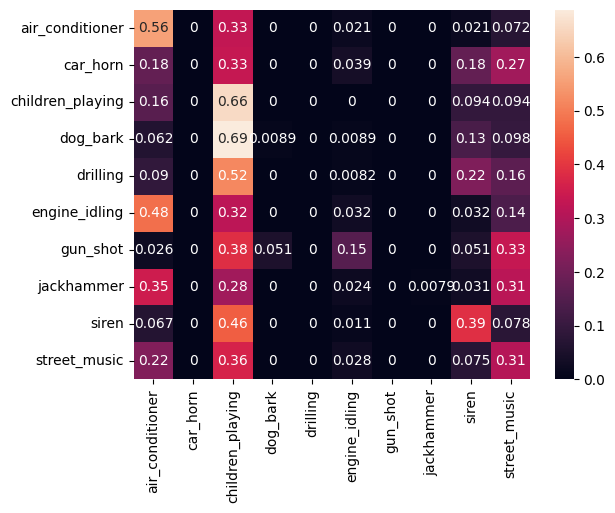

In [ ]:
plot_confusion_matrix(rnn_raw, val_dataloader, train_dataset.sr, device)

*Вопрос* : Сильно ли отличается качество модели на тренировочной и валидационной выборке? Если да, то как думаете, в чем причина?

Да, потому что возможно иногда соседные чистоты - разные звуки.

## Задание 3. Построение Мел-cпектрограмм. (2 балла)

Сырой сигнал очень чувствителен ко многим факторам - увеличение/уменьшение громкости, внешние шумы, сменение тембра говорящего очень резко меняют сырой сигнал. Это влияет и на качество глубоких сетей, обученных на сыром аудиосигнале.

Для построения надежных и устойчивых к переобучению моделей используют другое представление аудиоданных - спектрограммы, в том числе Мел-спектрограмму.

Идея её построения заключается в следующем:
1. Сигнал разбивается на временные интервалы (с пересечениями)
2. К каждому временному интервалу применяется фильтр (как правило косинусоидальный)
3. К профильтрованному сигналу применяется дискретное преобразование Фурье и вычисляются спектральные признаки сигнала.
4. Спектральные признаки с помощью логарифмического преобразования приводятся в Мел-шкалу.

<center>
<img src="https://antkillerfarm.github.io/images/img2/Spectrogram_5.png" height="550">
</center>

В этом задании мы сами шаг за шагом напишем алгоритм построения мелспектрограммы и сравнимся с референсной функцией из `torchaudio`.

In [ ]:
!pip install --upgrade transformers

In [ ]:
from torchaudio.transforms import MelSpectrogram


# референсная функця
def compute_log_melspectrogram_reference(wav_batch, lens, sr, device="cpu"):
    featurizer = MelSpectrogram(
        sample_rate=sr,
        n_fft=1024,
        win_length=1024,
        hop_length=256,
        n_mels=64,
        center=False,
    ).to(device)

    return torch.log(featurizer(wav_batch).clamp(1e-5)), lens // 256

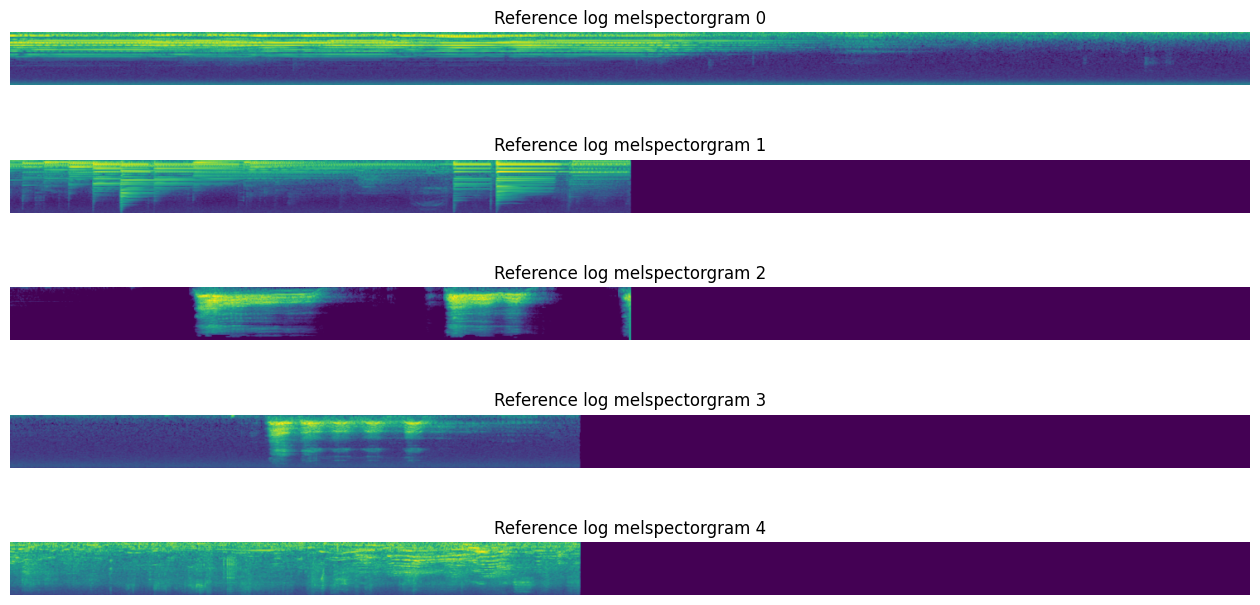

In [ ]:
# возьмем случайный батч
for batch in train_dataloader:
    break

wav_batch = batch["x"]
lens = batch["len"]

# посчитаем лог мелспектрограммы
log_melspect, lens = compute_log_melspectrogram_reference(
    wav_batch, lens, train_dataset.sr
)

# нарисуем получившиеся референсные значения
fig, axes = plt.subplots(5, figsize=(16, 8))

for i in range(5):
    axes[i].axis("off")
    axes[i].set_title(f"Reference log melspectorgram {i}")
    axes[i].imshow(log_melspect[i].numpy())

In [ ]:
print(wav_batch)

tensor([[-0.0144, -0.0177, -0.0186,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1700, -0.2202, -0.2577,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.0053, -0.0116, -0.0188,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1078,  0.0890,  0.0752,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0331,  0.0721,  0.1172,  ...,  0.0000,  0.0000,  0.0000]])


Теперь сделаем то же самое сами.

In [ ]:
sr = train_dataset.sr
n_fft = 1024
win_length = 1024
hop_length = 256
n_mels = 64


Для начала с помощью метода `unfold` разделим аудиосигнал на окна размера `win_lenght` через промежутки `hop_lenght`.

In [ ]:
import copy

windows = copy.deepcopy(wav_batch).unfold(1,win_length,hop_length)
assert windows.shape == (32, 1497, 1024)
print(windows)

tensor([[[-1.4435e-02, -1.7700e-02, -1.8555e-02,  ...,  2.7283e-02,
           2.8625e-02,  2.6184e-02],
         [-3.1952e-02, -3.4454e-02, -3.5187e-02,  ...,  1.8616e-02,
           1.0986e-02,  6.3171e-03],
         [ 1.0986e-03,  2.3499e-03, -2.2583e-03,  ..., -9.8267e-03,
          -6.8054e-03, -1.8921e-03],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -3.0518e-05,
          -3.0518e-05,  0.0000e+00],
         [-3.0518e-05,  0.0000e+00, -3.0518e-05,  ...,  0.0000e+00,
          -3.0518e-05,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         ...,
         [ 0.0000e+00,  0

Нарисуем и проиграем сигнал из одного окна.

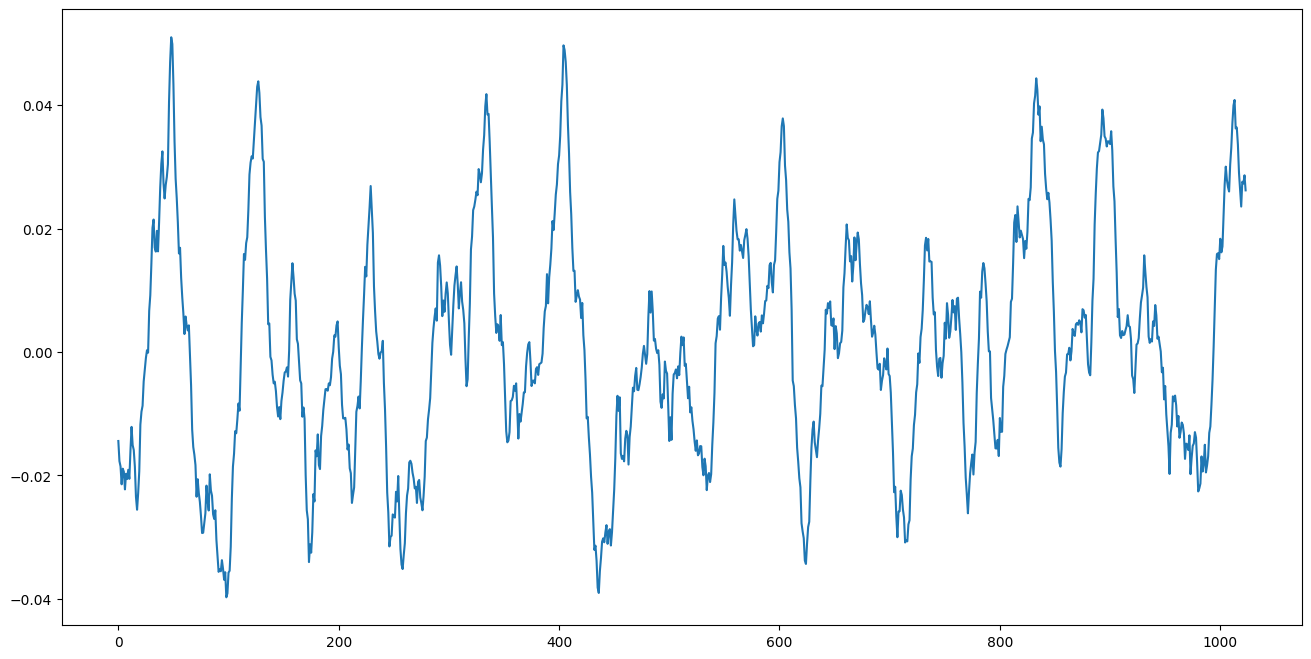

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(windows[0, 0])

display.Audio(windows[0, 0], rate=train_dataset.sr)

Теперь нам надо применить косинуисальный фильтр к сигналу из окна. Для этого с помощью `torch.hann_window` создадим косинусоидальный фильтр и умножим его поэлементно на все окна.

In [ ]:
filter = torch.hann_window(win_length,periodic = True, device = "cpu")
windows_with_applied_filter = windows * filter[None, None, :]
print(windows_with_applied_filter)

tensor([[[-0.0000e+00, -1.6669e-07, -7.0006e-07,  ...,  1.0294e-06,
           2.6958e-07,  0.0000e+00],
         [-0.0000e+00, -3.2447e-07, -1.3276e-06,  ...,  7.0237e-07,
           1.0346e-07,  0.0000e+00],
         [ 0.0000e+00,  2.2130e-08, -8.5205e-08,  ..., -3.7076e-07,
          -6.4090e-08, -0.0000e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.1514e-09,
          -2.8740e-10,  0.0000e+00],
         [-0.0000e+00,  0.0000e+00, -1.1514e-09,  ...,  0.0000e+00,
          -2.8740e-10,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         ...,
         [ 0.0000e+00,  0

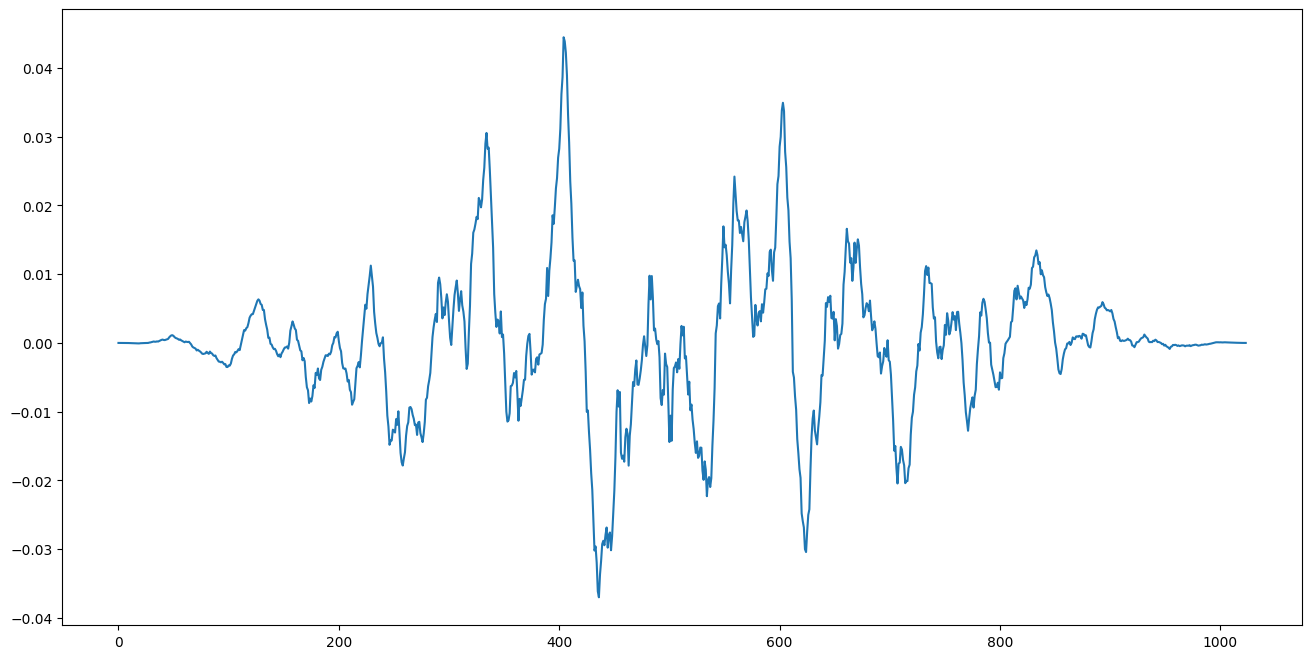

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(windows_with_applied_filter[0, 0])

display.Audio(windows_with_applied_filter[0, 0], rate=train_dataset.sr)

С помощью `torch.fft.fft` примените дискретное преобразование фурье к каждому окну и возьмите первые `n_fft // 2 + 1` компоненты.

Дальше с помощью возведения элементов тензора в квадрат и `torch.abs()` получите магнитуды.

In [ ]:
fft_features = torch.fft.fft(windows_with_applied_filter)[:,:,:win_length//2+1]
fft_magnitudes = torch.abs(fft_features**2)
assert fft_magnitudes.shape == (32, 1497, 513)
print(fft_features)

tensor([[[-4.6063e-03+0.0000e+00j,  1.3550e-01+4.0447e-01j,
          -2.2693e-01+3.4951e-01j,  ...,
          -5.5606e-03+6.9015e-04j,  1.0338e-03-3.4232e-04j,
           6.1110e-03+0.0000e+00j],
         [ 1.3993e+00+0.0000e+00j, -9.2593e-01+9.6858e-01j,
           1.1420e-01-8.5740e-01j,  ...,
           2.5890e-03+2.7779e-03j, -7.7982e-03-4.0217e-03j,
           1.0061e-02+0.0000e+00j],
         [ 2.2003e+00+0.0000e+00j, -1.2770e+00-1.6326e-01j,
          -2.1109e-01+6.8930e-01j,  ...,
           3.5271e-03-2.8854e-03j, -6.4016e-03+8.6251e-03j,
           5.2458e-03+0.0000e+00j],
         ...,
         [ 0.0000e+00+0.0000e+00j,  0.0000e+00+0.0000e+00j,
           0.0000e+00+0.0000e+00j,  ...,
          -0.0000e+00+0.0000e+00j, -0.0000e+00+0.0000e+00j,
           0.0000e+00+0.0000e+00j],
         [ 0.0000e+00+0.0000e+00j,  0.0000e+00+0.0000e+00j,
           0.0000e+00+0.0000e+00j,  ...,
          -0.0000e+00+0.0000e+00j, -0.0000e+00+0.0000e+00j,
           0.0000e+00+0.0000e+00j],
 

Через `torchaudio.transforms.MelScale` создайте класс для перевода магнитуд в Мел-шкалу.

In [ ]:
melscale = torchaudio.transforms.MelScale(sample_rate = sr, n_mels = 64, n_stft = win_length//2+1)

Нелинейное преобразование для перевода в Мел-шкалу выглядит следующим образом.

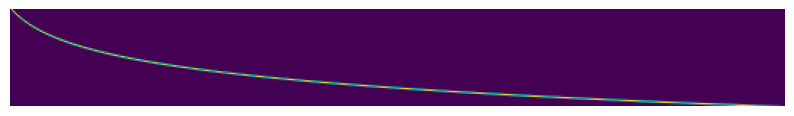

In [ ]:
plt.figure(figsize=(10, 5))
plt.axis("off")
plt.imshow(melscale.fb.numpy().transpose())


Примените Мел-шкалу к магнитудам.

In [ ]:
mel_spectrogram = melscale(torch.transpose(fft_magnitudes,1,2))
print(mel_spectrogram.shape)  # your code here
assert mel_spectrogram.shape == (32, 64, 1497)
print(mel_spectrogram)

torch.Size([32, 64, 1497])
tensor([[[1.6156e-01, 1.5943e+00, 1.4717e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.6573e-01, 8.2743e-01, 6.2074e-01,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [7.3190e-01, 1.1953e+00, 6.4120e-01,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [3.5657e-02, 3.5197e-02, 3.6465e-02,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [2.0479e-02, 2.6702e-02, 2.3068e-02,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [8.9441e-03, 1.1654e-02, 8.8767e-03,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]],

        [[8.5731e-06, 1.0717e-05, 3.0783e-05,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [7.2514e-06, 8.8224e-06, 6.3171e-06,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.6974e-06, 3.7419e-06, 4.8266e-07,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [1.3025e-06, 1.0496e-06, 1.2642e-06,  ..., 

Сделайте обрезку значений по `1e-5` и примените `torch.log` для получения логарифмированной Мел-спектрограммы.

In [ ]:
logmel_spectrogram = torch.log(mel_spectrogram.clamp(min = 1e-5))  # your code here
assert logmel_spectrogram.shape == (32, 64, 1497)

Полученные логарифмированные Мел-Спектрограммы должны совпадать с референсными.

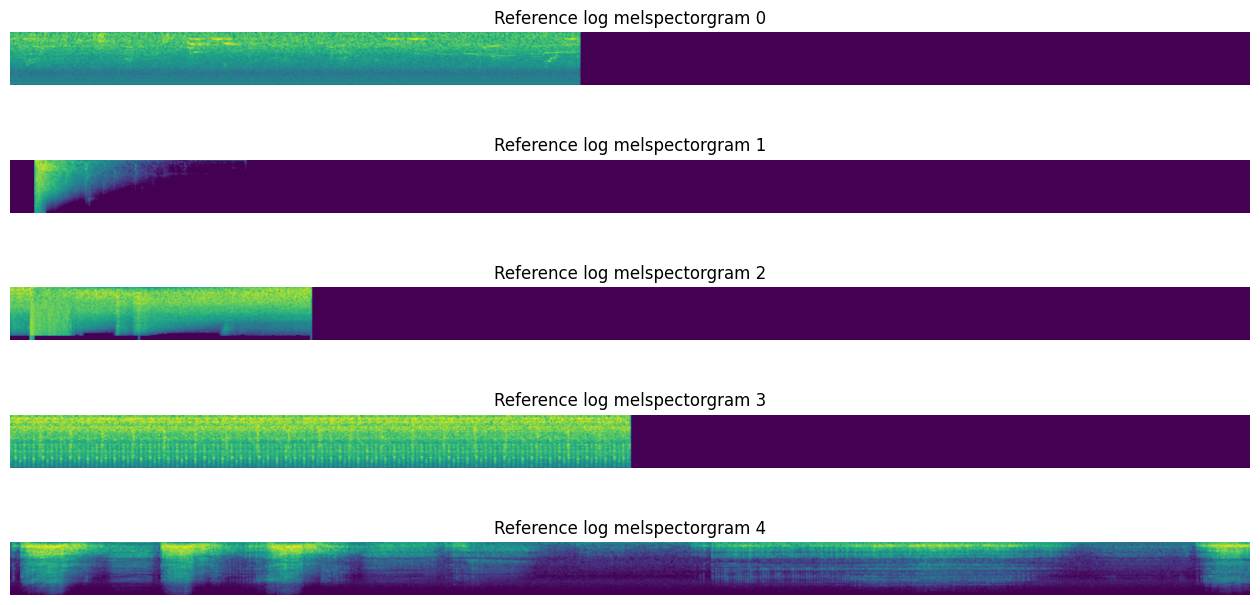

In [ ]:
# нарисуем получившиеся референсные значения
fig, axes = plt.subplots(5, figsize=(16, 8))

for i in range(5):
    axes[i].axis("off")
    axes[i].set_title(f"Reference log melspectorgram {i}")
    axes[i].imshow(log_melspect[i].numpy())

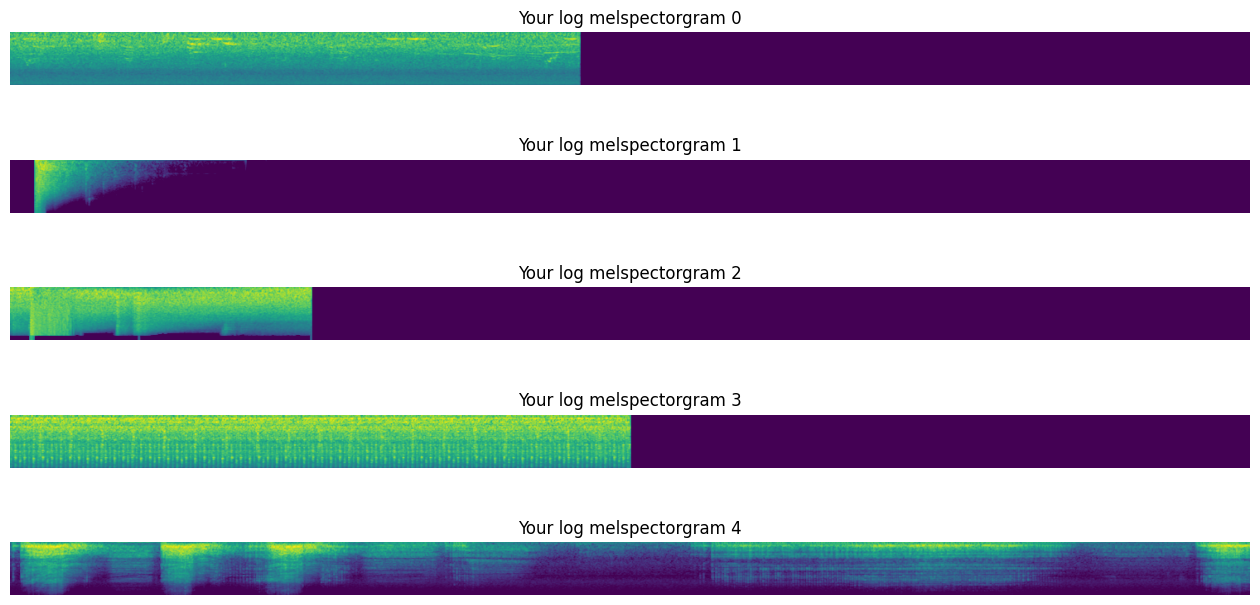

In [ ]:
# нарисуем получившиеся значения
fig, axes = plt.subplots(5, figsize=(16, 8))

for i in range(5):
    axes[i].axis("off")
    axes[i].set_title(f"Your log melspectorgram {i}")
    axes[i].imshow(logmel_spectrogram[i].numpy())

In [ ]:
print(logmel_spectrogram[0])

tensor([[ -1.8229,   0.4664,   0.3864,  ..., -11.5129, -11.5129, -11.5129],
        [ -1.7974,  -0.1894,  -0.4768,  ..., -11.5129, -11.5129, -11.5129],
        [ -0.3121,   0.1784,  -0.4444,  ..., -11.5129, -11.5129, -11.5129],
        ...,
        [ -3.3338,  -3.3468,  -3.3114,  ..., -11.5129, -11.5129, -11.5129],
        [ -3.8884,  -3.6230,  -3.7693,  ..., -11.5129, -11.5129, -11.5129],
        [ -4.7168,  -4.4521,  -4.7243,  ..., -11.5129, -11.5129, -11.5129]])


Теперь оформим эту логику в функцию.

In [ ]:

def compute_log_melspectrogram(wav_batch, lens, sr, device="cpu"):

    import copy

    windows = copy.deepcopy(wav_batch).unfold(1,win_length,hop_length)


    filter = torch.hann_window(win_length,periodic = True, device = "cpu")
    windows_with_applied_filter = windows * filter[None, None, :]


    fft_features = torch.fft.fft(windows_with_applied_filter)[:,:,:win_length//2+1]
    fft_magnitudes = torch.abs(fft_features**2)

    melscale = torchaudio.transforms.MelScale(n_mels=n_mels, sample_rate = sr, n_stft = n_fft // 2 + 1).to(device)
    mel_spectrogram = melscale(torch.transpose(fft_magnitudes,1,2))

    logmel_spectrogram = torch.log(mel_spectrogram.clamp(min = 1e-5))  # your code here


    return logmel_spectrogram, lens//256

Финальная проверка.

In [ ]:
assert torch.allclose(
    compute_log_melspectrogram_reference(wav_batch, lens, train_dataset.sr)[0],
    compute_log_melspectrogram(wav_batch, lens, train_dataset.sr)[0],
    atol=1e-5,
)


In [ ]:
compute_log_melspectrogram_reference(wav_batch, lens, train_dataset.sr)[0] - compute_log_melspectrogram(wav_batch, lens, train_dataset.sr)[0]

In [ ]:
compute_log_melspectrogram(wav_batch, lens, train_dataset.sr)[0],

(tensor([[ -1.8229,   0.4664,   0.3864,  ..., -11.5129, -11.5129, -11.5129],
         [ -1.7974,  -0.1894,  -0.4768,  ..., -11.5129, -11.5129, -11.5129],
         [ -0.3121,   0.1784,  -0.4444,  ..., -11.5129, -11.5129, -11.5129],
         ...,
         [ -3.3338,  -3.3468,  -3.3114,  ..., -11.5129, -11.5129, -11.5129],
         [ -3.8884,  -3.6230,  -3.7693,  ..., -11.5129, -11.5129, -11.5129],
         [ -4.7168,  -4.4521,  -4.7243,  ..., -11.5129, -11.5129, -11.5129]]),)

In [ ]:
compute_log_melspectrogram(wav_batch, lens, train_dataset.sr).shape
wav_batch.shape

torch.Size([32, 384000])

## Задание 4. Рекуррентная сеть для классификации аудиозаписей по логарифмированным Мел-спектрограммам (1 балл)

Измените реализацию рекуррентной сети из задания 2, таким образом, чтобы она вместо сырого сигнала смогла принимать логарифмированные Мел-спетрограммы:
1. Уберите шаги 1-2
2. Сделайте вход LSTM равным 64

<center>
<img src="https://raw.githubusercontent.com/hse-ds/iad-applied-ds/2020-2023/2022/hw/hw2/imgs/rnn_mel.png" height="500">
</center>

**За реализацию архитектуры дается 0.5 балла.**

In [ ]:
class RecurrentMelSpectClassifier(nn.Module):
    def __init__(
        self,
        num_classes=10,
        window_length=1024,
        hop_length=256,
        hidden=256,
        num_layers=2,
    ) -> None:
        super().__init__()

        self.window_length = window_length
        self.hop_length = hop_length

        ### YOUR CODE IS HERE ######
        self.hidden_size = 200
        self.rnn = nn.LSTM(bidirectional = True, num_layers = 4, input_size = 64, hidden_size = self.hidden_size , batch_first = True)

        self.final_mlp = final_mlp = nn.Sequential(
            nn.BatchNorm1d(self.hidden_size *num_layers*2*2),
            nn.Linear(self.hidden_size *num_layers*2*2,256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256,10),
            nn.Sigmoid())
        ### THE END OF YOUR CODE ###

    def forward(self, x, lens):
        ### YOUR CODE IS HERE ######
        after_LSTM = self.rnn(torch.transpose(x,1,2))[1][0]

        hidden_state_cat = torch.cat((after_LSTM[0],after_LSTM[1],after_LSTM[2],after_LSTM[3],after_LSTM[4],after_LSTM[5],after_LSTM[6],after_LSTM[7]), dim = 1)
        print(hidden_state_cat.shape)
        return(self.final_mlp(hidden_state_cat))
        ### THE END OF YOUR CODE ###

In [ ]:
rnn_mel = RecurrentMelSpectClassifier()
rnn_mel.to(device)

optim = torch.optim.AdamW(rnn_mel.parameters(), lr=3e-4)

Epoch 9


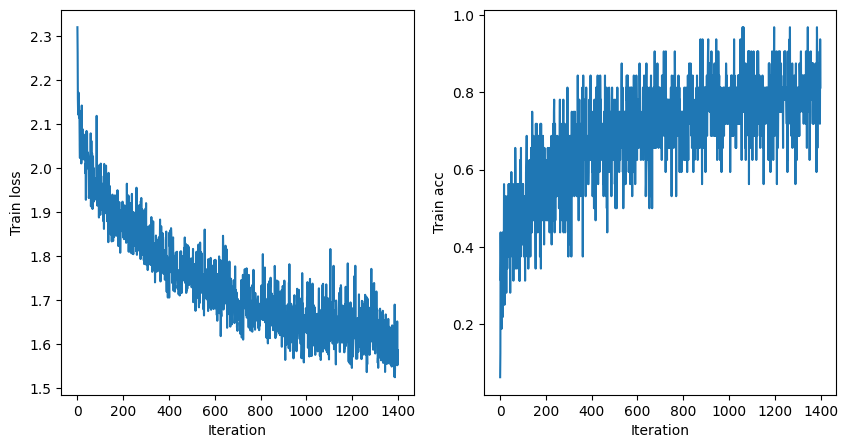

In [ ]:
train_audio_clfr(
    rnn_mel,
    optim,
    train_dataloader,
    train_dataset.sr,
    data_transform=compute_log_melspectrogram_reference,
)

Посчитаем метрики на валидационном датасете.

**Задание: для получения 0.5 балла сделайте подбор гиперпараметров и добейтесь accuracy модели выше 0.8 на валидационном датасете.**

In [ ]:
plot_confusion_matrix(
    rnn_mel,
    val_dataloader,
    train_dataset.sr,
    device,
    data_transform = compute_log_melspectrogram_reference,
)

NameError: name 'plot_confusion_matrix' is not defined

## Задание 5. Cверточная сеть для классификации аудиозаписей по мелспектрограммам. (2 балла)

Легко заметить, что мелспектрограммы имеют четко выраженные паттерны - если приноровиться, то даже человек, посмотрев на мелспектрограмму, сможет _визуально_ проклассифицировать объект.

Это позволяет свести задачу классификации аудиозаписей к задаче классификации картинок.

Реализуем такую сверточную сеть:

* 2x (Conv2d 3x3 @ 16, BatchNorm2d, ReLU)
* MaxPoll 2x2
* 2x (Conv2d 3x3 @ 32, BatchNorm2d, ReLU)
* MaxPoll 2x2
* 2x (Conv2d 3x3 @ 64, BatchNorm2d, ReLU)
* MaxPoll 2x2
* (Conv2d 3x3 @ 128, BatchNorm2d, ReLU)
* (Conv2d 2x2 @ 128, BatchNorm2d, ReLU)
* Global MaxPoll
* Fully Connected 128, ReLU
* Fully Connected 10

Совет: подобная архитектура была реализована в [**PANNs: Large-Scale Pretrained Audio Neural Networks for Audio Pattern Recognition**](https://arxiv.org/pdf/1912.10211.pdf), можете использовать эту статью как референс.


**За реализацию архитектуры дается 1.5 балла.**

In [ ]:
m = nn.Conv2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2), dilation=(3, 1))
input = torch.randn(20, 16, 50, 100)
m(input).shape

torch.Size([20, 33, 26, 100])

In [ ]:
class CNN10(nn.Module):
    def __init__(self, num_classes=10, hidden=16):
        super().__init__()

        ### YOUR CODE IS HERE ######
        self.cnn_backbone = nn.Sequential(
            nn.Conv2d(1,16, 3, stride = 1, padding = 1),
            nn.Conv2d(16,16, 3, stride = 1, padding = 1),
            nn.MaxPool2d(2),
            nn.Conv2d(16,32, 3, stride = 1, padding = 1),
            nn.Conv2d(32,32, 3, stride = 1, padding = 1),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64, 3, stride = 1, padding = 1),
            nn.Conv2d(64,64, 3, stride = 1, padding = 1),
            nn.MaxPool2d(2),
            nn.Conv2d(64,128, 3, stride = 1, padding = 1),
            nn.Conv2d(128,128, 3, stride = 1, padding = 1)
            )

        self.final_mlp = nn.Sequential(
            nn.Linear(128,128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128,10),
            nn.Sigmoid()
            )
        ### THE END OF YOUR CODE ###

    def forward(self, x, lens):
        print(x[:, None, :, :].shape)
        z = self.cnn_backbone(x[:, None, :, :])
        z = torch.nn.functional.max_pool2d(z, kernel_size=z.size()[2:])[:, :, 0, 0]
        return self.final_mlp(z)

In [ ]:
cnn = CNN10()
cnn.to(device)

optim = torch.optim.Adam(cnn.parameters(), lr=3e-4)

Epoch 19


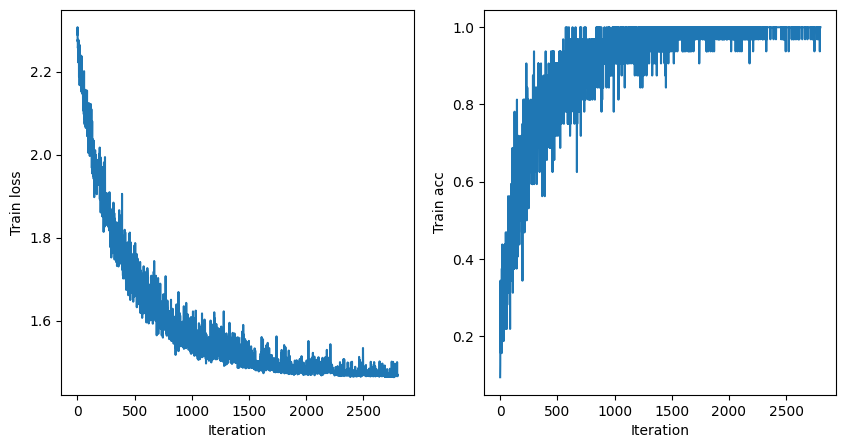

In [ ]:
train_audio_clfr(
    cnn,
    optim,
    train_dataloader,
    train_dataset.sr,
    data_transform=compute_log_melspectrogram_reference,
    num_epochs=20,
)

**Задание: для получения 0.5 балла сделайте подбор гиперпараметров и добейтесь accuracy модели выше 0.85 на валидационном датасете.**

torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([7, 1, 64, 1497])
Val accuracy: 0.9197860962566845


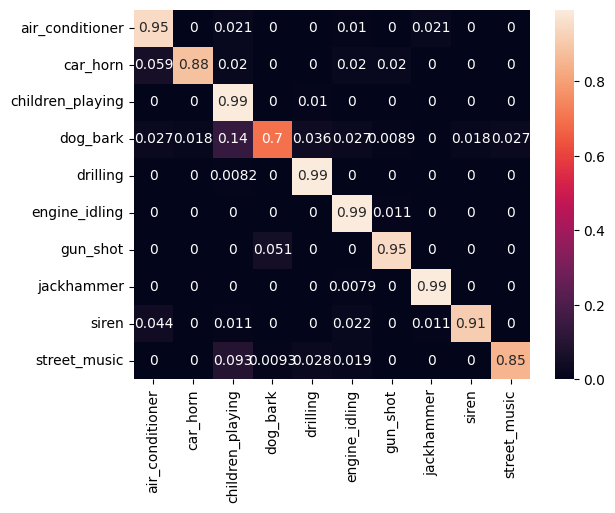

In [ ]:
plot_confusion_matrix(
    cnn,
    val_dataloader,
    train_dataset.sr,
    device,
    data_transform=compute_log_melspectrogram_reference,
)

## Задание 6. Аугментация SpecAugment (2 балла)

Обычно датасеты с аудиозаписями довольно малы. Наш датасет тому пример - всего 4500 объектов в обучающей выборке. Обучение глубокий сетей с большим кол-вом параметров на таких датасетах часто ведет к переобучению и проседанию метрик на валидационном и тестовом датасетах.

Для борьбы с переобучением имеет смысл использовать аугментацию данных. Для мелспектрограмм была придумана аугментация под названием SpecAugment.

Смысл её очень прост - зануление спектрограммы по временным промежуткам и по мел-частотам:
1. Выбираются несколько временных промежутков ${[t^1_i, t^2_i]}$ и заполняют спектрограмму $s[t^1_i : t^2_i, :]$ значением $v$.

2. Выбираются несколько промежутков мелчастот ${[m^1_i, m^2_i]}$ и заполняют спектрограмму $s[:, m^1_i : m^2_i]$ значением $v$.

В качестве значения $v$ выбирают:
1. `'mean'`: среднее по спектрограмме
2. `'min'`: минимум по спектрограмме
3. `'max'`: максимум по спектрограмме
5. `v`: некоторая константа

Совет: описание аугментации можно найти здесь: [link](https://neurohive.io/ru/novosti/specaugment-novyj-metod-augmentacii-audiodannyh-ot-google-ai/), можете использовать эту ссылку как референс.

![specaugment](https://neurohive.io/wp-content/uploads/2019/04/image6.png)

В этом задании Вам предлагается реализовать аугментацию SpecAugment.

**За реализацию аугментации дается 1.5 балла.**


In [ ]:
import random


class SpectAugment:
    def __init__(
        self,
        filling_value="mean",
        n_freq_masks=2,
        n_time_masks=2,
        max_freq=10,
        max_time=50,
    ):

        self.filling_value = filling_value
        self.n_freq_masks = n_freq_masks
        self.n_time_masks = n_time_masks
        self.max_freq = max_freq
        self.max_time = max_time

    def __call__(self, spect, lens):
        cloned_spect = spect.clone()
        print(spect.shape)
        ### YOUR CODE IS HERE ######
        for j in range(cloned_spect.shape[0]):
          times_quant =  self.n_time_masks
          mel_numb = self.n_freq_masks
          value = torch.mean(cloned_spect[j,:,:])

          for i in range(mel_numb):
            harass_len = np.random.randint(-2, 3)
            harass_start = np.random.randint(0,64)
            cloned_spect[j,min(max(0,harass_start + harass_len),harass_start):max(min(64, harass_len + harass_start), harass_start),:] = value

          for j in range(times_quant):
            time_len = cloned_spect.shape[2]
            harass_len = np.random.randint(-time_len//60, time_len//60+1)
            harass_start = np.random.randint(0,time_len)
            cloned_spect[j,:,min(max(0,harass_start + harass_len),harass_start):max(min(64, harass_len + harass_start), harass_start)] = value

        return cloned_spect, lens
        ### THE END OF YOUR CODE ###

torch.Size([32, 64, 1497])


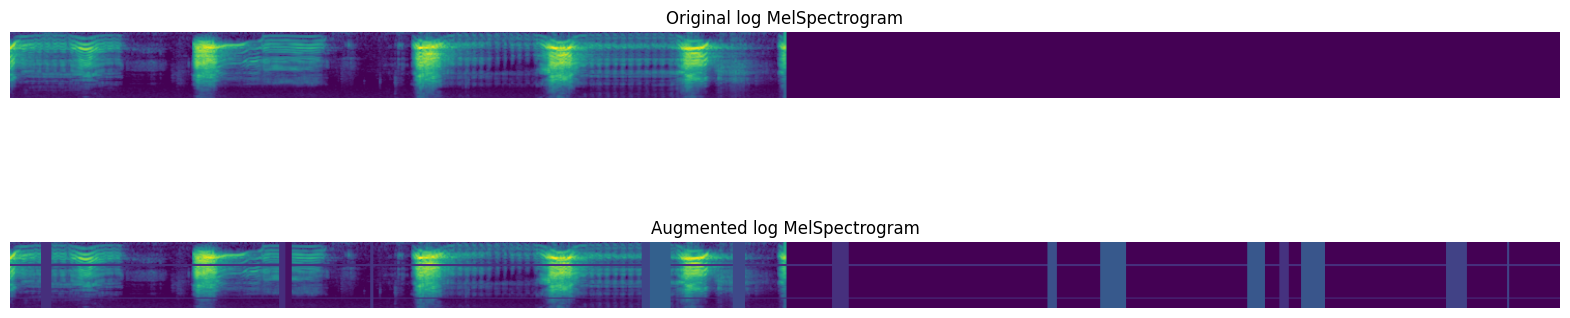

In [ ]:
# применим аугментацию к данным
for batch in train_dataloader:
    break

x = batch["x"].to(device)
lens = batch["len"].to(device)
x_logmel, lens = compute_log_melspectrogram_reference(
    x, lens, sr=train_dataset.sr, device=device
)
x_logmel_augmented, lens = SpectAugment()(x_logmel, lens)

# нарисуем спектрограмму до и после аугментации
plt.figure(figsize=(20, 5))
plt.subplot(2, 1, 1)
plt.title("Original log MelSpectrogram")
plt.axis("off")
plt.imshow(x_logmel[0].cpu().numpy())

plt.subplot(2, 1, 2)
plt.title("Augmented log MelSpectrogram")
plt.axis("off")
plt.imshow(x_logmel_augmented[0].cpu().numpy())

plt.show()

In [ ]:
cnn = CNN10()
cnn.to(device)

optim = torch.optim.Adam(cnn.parameters(), lr=3e-4)

Epoch 19


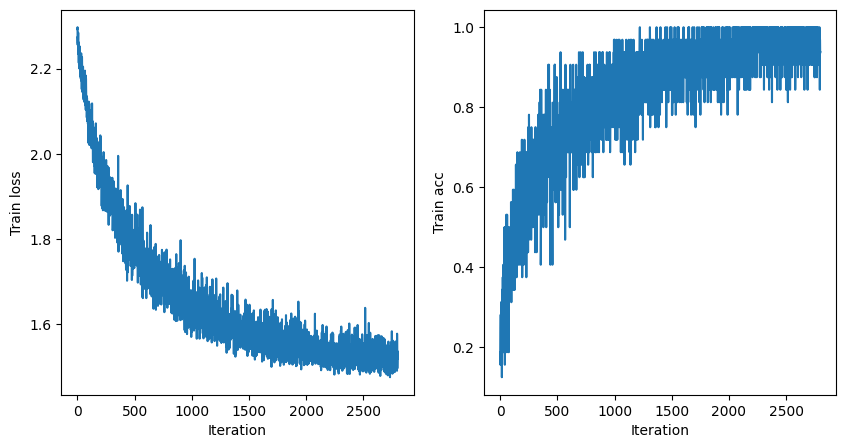

In [ ]:
# обучим модель на данных с аугментациями
train_audio_clfr(
    cnn,
    optim,
    train_dataloader,
    train_dataset.sr,
    data_transform=compute_log_melspectrogram_reference,
    augmentation=SpectAugment(),
    num_epochs=20,
)

**Задание: для получения 0.5 балла сделайте подбор параметров аугментации и добейтесь accuracy модели выше 0.9 на валидационном датасете.**

torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([32, 1, 64, 1497])
torch.Size([7, 1, 64, 1497])
Val accuracy: 0.9112299465240642


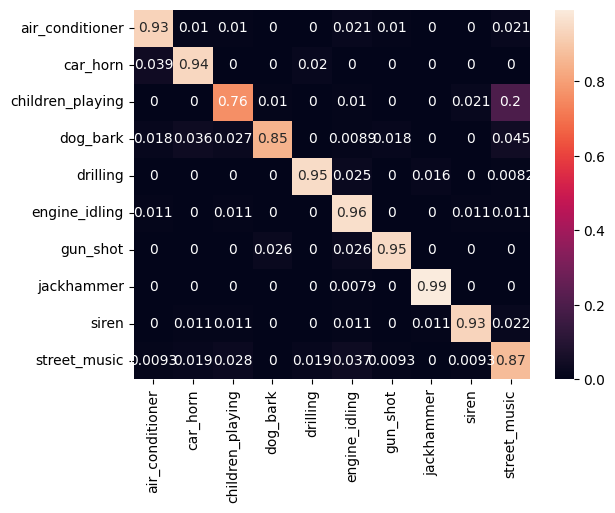

In [ ]:
plot_confusion_matrix(
    cnn,
    val_dataloader,
    train_dataset.sr,
    device,
    data_transform=compute_log_melspectrogram_reference,
)